In [1]:
import pandas as pd
from pybliometrics.scopus import ScopusSearch, CitationOverview

In [2]:
import matplotlib.pyplot as plt
plt.style.use('hello.mplstyle')

In [3]:
import numpy as np

In [5]:
df1 = pd.read_csv('CORE.csv')
df2 = pd.read_excel('CCF.xlsx')

In [6]:
m1 = pd.merge(df1,df2,on='conf') # общее в CORE и CCF
# CCF и Microsoft не имеют общих конференций, поэтому не берем
res = pd.concat([df1, df2, m1]).drop_duplicates(subset=['conf'],keep='last')
# объединяем CORE, CCF, Microsoft и общее; убираем дубли и оставляем last, потому что там общее.

,2189,conf,ANT,CORE2020,Unranked,Yes,4606,Unnamed: 7,Unnamed: 8,CCF
0,11.0,"ACM Conference on Applications, Technologies, ...",SIGCOMM,CORE2020,A*,No,4606.0,NaN,NaN,NaN
1,15.0,ACM Conference on Embedded Networked Sensor Sy...,SENSYS,CORE2020,A*,Yes,4606.0,NaN,NaN,NaN
2,16.0,ACM Conference on Embedded Software,EMSOFT,CORE2020,A,Yes,4606.0,NaN,NaN,NaN
3,24.0,ACM International Conference on Emerging Netwo...,CoNEXT,CORE2020,A,No,4606.0,NaN,NaN,NaN
4,27.0,ACM International Conference on Mobile Computi...,MOBICOM,CORE2020,A*,No,4606.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5,905.0,International Conference on Algorithms and Arc...,ICA3PP,CORE2020,B,No,4606.0,NaN,NaN,С(18)
6,1002.0,International Conference on Distributed Comput...,ICDCS,CORE2020,A,Yes,4606.0,NaN,NaN,B(12)
7,1164.0,International Conference on Parallel and Distr...,ICPADS,CORE2020,B,No,4606.0,NaN,NaN,С(21)
8,1167.0,International Conference on Parallel Processing,ICPP,CORE2020,A,Yes,4606.0,NaN,NaN,B(17)


In [7]:
res = res.drop(["2189", "ANT", "CORE2020","Yes","4606", "Unnamed: 7", "Unnamed: 8"],axis=1).replace(np.nan, '-').reset_index(drop="True")
#         убираем ненужные столбцы                     ////////////                         меняем NaN на "-" // восстанавливаем правильный порядок 

In [8]:
res

,conf,Unranked,CCF
0,"ACM Conference on Applications, Technologies, ...",A*,-
1,ACM Conference on Embedded Networked Sensor Sy...,A*,-
2,ACM Conference on Embedded Software,A,-
3,ACM International Conference on Emerging Netwo...,A,-
4,ACM International Conference on Mobile Computi...,A*,-
...,...,...,...
237,International Conference on Algorithms and Arc...,B,С(18)
238,International Conference on Distributed Comput...,A,B(12)
239,International Conference on Parallel and Distr...,B,С(21)
240,International Conference on Parallel Processing,A,B(17)


In [8]:
# списки для MultiIndex
years = [i for i in range (2011, 2021)]
count = [('Works') for i in range (2011, 2021)]
cit_count = [('Citations') for i in range (2011, 2021)]

In [10]:
# пустой датафрейм, чтобы было, к чему сшивать
begin = pd.DataFrame([], columns=years)

In [11]:
resultw = pd.DataFrame([])

for eid in res['conf'].tolist():
    
    # убираем скобки, из-за которых ломается поиск в Скопусе
    disallowed_characters = "()"            
    
    for character in disallowed_characters:
        eid = eid.replace(character, "")
    
    a = 'CONF ( {} ) AND  PUBYEAR  >  2010 AND  PUBYEAR  <  2021 AND AFFILCOUNTRY ( russian  AND federation )'.format(eid)
    s = ScopusSearch(a)
    
    df = pd.DataFrame(pd.DataFrame(s.results))
    
    # пропуск, если результатов нет
    if df.empty != True:
        df['coverDate'] = pd.DatetimeIndex(df['coverDate']).year # меняем данные на формат .year
        
        temp1 = pd.DataFrame(df.value_counts(subset=['coverDate']), columns=['count']) # считаем публикации
        temp1 = temp1.rename_axis(None).transpose() # переворачиваем, потому что костыли надо вертеть
        temp1.columns = temp1.columns.get_level_values(0) # лечим то, что программа считает, что это мультииндекс

        temp2 = begin.merge(temp1,how='outer') #объединяем результаты
        temp2.index=['{}'.format(eid)] # подписываем конференцию

        resultw = pd.concat([resultw,temp2]).replace(np.nan, '-') # меняем NaN на - для ГОСТа

In [15]:
resultw2 = pd.DataFrame([])

for eid in res['conf'].tolist():
    
    disallowed_characters = "()"
    
    for character in disallowed_characters:
        eid = eid.replace(character, "")
        
    a2 = 'CONF ( {} ) AND  PUBYEAR  >  2010 AND  PUBYEAR  <  2021'.format(eid)
    s2 =  ScopusSearch(a2)
    
    df = pd.DataFrame(pd.DataFrame(s2.results))
    
    if df.empty != True:
        df['coverDate'] = pd.DatetimeIndex(df['coverDate']).year

        temp1 = pd.DataFrame(df.value_counts(subset=['coverDate']), columns=['count']) # считаем публикации
        temp1 = temp1.rename_axis(None).transpose()
        temp1.columns = temp1.columns.get_level_values(0)

        temp2 = begin.merge(temp1,how='outer')
        temp2.index=['{}'.format(eid)]

        resultw2 = pd.concat([resultw2,temp2]).replace(np.nan, '-')

In [16]:
resultw.columns = pd.MultiIndex.from_arrays([count, resultw.columns]) # две строчки-названия
resultw2.columns = pd.MultiIndex.from_arrays([count, resultw2.columns])

In [20]:
# ==== цитирования!

resultc = pd.DataFrame([])

for eid in res['conf'].tolist():
    
    disallowed_characters = "()"
    
    for character in disallowed_characters:
        eid = eid.replace(character, "")

    a = 'CONF ( {} ) AND  PUBYEAR  >  2010 AND  PUBYEAR  <  2021 AND AFFILCOUNTRY ( russian  AND federation )'.format(eid)
    s = ScopusSearch(a, subscriber=False)
    df = pd.DataFrame(pd.DataFrame(s.results))
    
    if df.empty != True:
        df['coverDate'] = pd.DatetimeIndex(df['coverDate']).year

        temp1 = df.groupby('coverDate').sum('citedby_count').drop('openaccess', axis=1) # убираем что-то, что непонятно откуда взялось и мешаеет
        temp1 = temp1.rename_axis(None).transpose() # переворачиваем
        temp1.columns = temp1.columns.get_level_values(0) # лечим MultiIndex


        temp2 = begin.merge(temp1,how='outer')
        temp2.index=['{}'.format(eid)]

        resultc = pd.concat([resultc,temp2]).replace(np.nan, '-')

In [19]:
resultc2 = pd.DataFrame([])

for eid in res['conf'].tolist():
    
    disallowed_characters = "()"
    
    for character in disallowed_characters:
        eid = eid.replace(character, "")

    a2 = 'CONF ( {} ) AND  PUBYEAR  >  2010 AND  PUBYEAR  <  2021'.format(eid)
    s2 = ScopusSearch(a2)
    df = pd.DataFrame(pd.DataFrame(s2.results))
    
    if df.empty != True:
        df['coverDate'] = pd.DatetimeIndex(df['coverDate']).year

        temp1 = df.groupby('coverDate').sum('citedby_count').drop('openaccess', axis=1)
        temp1 = temp1.rename_axis(None).transpose()
        temp1.columns = temp1.columns.get_level_values(0)


        temp2 = begin.merge(temp1,how='outer')
        temp2.index=['{}'.format(eid)]

        resultc2 = pd.concat([resultc2,temp2]).replace(np.nan, '-')

In [21]:
resultc.columns = pd.MultiIndex.from_arrays([cit_count, resultc.columns])
resultc2.columns = pd.MultiIndex.from_arrays([cit_count, resultc2.columns])

In [22]:
# ====== объединяем!!

result1 = resultw.join(resultc).replace(np.nan, '-')
result1.index.name = None

In [23]:
result2 = resultw2.join(resultc2).replace(np.nan, '-')
result2.index.name = None

In [24]:
ranks = [('Rankings') for i in range (3)] # MultiIndex
addr = res.set_index('conf').rename_axis(None)
addr.columns = pd.MultiIndex.from_arrays([ranks, addr.columns])

Rankings                 
                                                   Unranked    CCF Microsoft
ACM Conference on Applications, Technologies, A...       A*      -         -
ACM Conference on Embedded Networked Sensor Sys...       A*      -         -
ACM Conference on Embedded Software                       A      -         -
ACM International Conference on Emerging Networ...        A      -         -
ACM International Conference on Mobile Computin...       A*      -         -
...                                                     ...    ...       ...
International Conference on Distributed Computi...        A  B(12)         -
International Conference on Parallel and Distri...        B  С(21)         -
International Conference on Parallel Processing           A  B(17)         -
International Conference on Virtual Execution E...        A  B(19)         -
International Conference on Concurrency Theory            A      -        64

[417 rows x 3 columns]

In [25]:
russia = pd.merge(addr, result1, left_index=True, right_index=True) # Russia
world = pd.merge(addr, result2, left_index=True, right_index=True) # World

In [4]:
# из ГОСТ в удобный для подсчётов
world = world.replace('-', np.nan)
russia = russia.replace('-', np.nan)

In [5]:
world_in_ru = world[world.index.isin(russia.index)]

In [7]:
# WORLD

TO_w = pd.DataFrame([world_in_ru['Works'].sum(axis=1)], index=['Total output']).transpose() # Total output
TCS_w = pd.DataFrame([world_in_ru['Citations'].sum(axis=1)], index=['TCS']).transpose()
CPP_w = pd.DataFrame([TCS_w['TCS']/TO_w['Total output']], index=['CPP']).transpose()
W_res = pd.merge(pd.merge(TO_w,TCS_w,left_index=True, right_index=True),CPP_w,left_index=True, right_index=True)

$$
MNCS = \frac{1}{n} \sum_{i=1}^n{\frac{c_i}{e_i}}
$$

In [9]:
#  Считаем MNCS для России

MNCS_ci = russia['Citations']/russia['Works']
MNCS_ei = world_in_ru['Citations']/world_in_ru['Works']
MNCS_sum = (MNCS_ci/MNCS_ei).sum(axis=1)
MNCS_list = MNCS_sum*0.1

In [10]:
# RUSSIA

TO_r = pd.DataFrame([russia['Works'].replace('-', np.nan).sum(axis=1)], index=['Total output (Russia)']).transpose()
TCS_r = pd.DataFrame([russia['Citations'].replace('-', np.nan).sum(axis=1)], index=['TCS (Russia)']).transpose()
CPP_r = pd.DataFrame([TCS_r['TCS (Russia)']/TO_r['Total output (Russia)']], index=['CPP (Russia)']).transpose()
MNCS_r = pd.DataFrame([MNCS_list], index=['MNCS (Russia)']).transpose()
R_res = pd.merge(pd.merge(TO_r,TCS_r,left_index=True, right_index=True),CPP_r,left_index=True, right_index=True)
R_res = pd.merge(R_res,MNCS_r, left_index=True, right_index=True)

In [12]:
Result = pd.merge(pd.merge(W_res, R_res, left_index=True, right_index=True), world_in_ru['Rankings'], left_index=True, right_index=True).rename(columns={"Unranked": "CORE"})

In [15]:
from scipy import stats

In [48]:
# проверяем, подчиняется ли CPP нормальному распределению
def kstest(x):
    if stats.kstest(x, 'norm')[1] < 0.05:
        print('Значение p = ' + str(stats.kstest(x, 'norm')[1]) + ' < 0.5\nКритерий Колмогорова-Смирнова не выполняется, распределение не подчиняется нормальному закону')

    else:
        print('Значение p = ' + str(stats.kstest(x, 'norm')[1]) + ' > 0.5\nКритерий Колмогорова-Смирнова не выполняется, распределение не подчиняется нормальному закону')

In [62]:
print('\033[1m' + 'Проверка критерия Колмогорова-Смирнова для мира (конференции, где есть Россия):' + '\033[0m')
kstest(Result['CPP'])

print('\033[1m' + 'Проверка критерия Колмогорова-Смирнова для мира (все конференции):' + '\033[0m')
kstest(CPP_General)

print('\033[1m' + 'Проверка критерия Колмогорова-Смирнова для России' + '\033[0m')
kstest(Result['CPP (Russia)'])

Проверка критерия Колмогорова-Смирнова для мира (конференции, где есть Россия):
Значение p = 1.3377241259116891e-149 < 0.5
Критерий Колмогорова-Смирнова не выполняется, распределение не подчиняется нормальному закону
Проверка критерия Колмогорова-Смирнова для мира (все конференции):
Значение p = 1.98585967774429e-270 < 0.5
Критерий Колмогорова-Смирнова не выполняется, распределение не подчиняется нормальному закону
Проверка критерия Колмогорова-Смирнова для России
Значение p = 3.3178806742177435e-73 < 0.5
Критерий Колмогорова-Смирнова не выполняется, распределение не подчиняется нормальному закону


Так как гипотеза Колмогорова-Смирнова не выполняется и распределение не подчиняется нормальному закону, проверить корелляцию по Пирсону не представляется возможным. Проверить корелляцию тау-b Кендалла нельзя, потому что выборка не является случайной. Проверим корреляцию ро Спирмена.

In [70]:
def spearman(x,y):

    if stats.spearmanr(x, y)[1] <= 0.01:
        print('Значение p = ' + str(stats.spearmanr(x, y)[1]) + ' < 0.01\nГипотеза H0 не выполняется, корреляция есть\nУровень корреляции = ' + str(stats.spearmanr(x, y)[0]))

    elif stats.spearmanr(x, y)[1] >= 0.1:
        print('Значение p = ' + str(stats.spearmanr(x, y)[1]) + ' > 0.1\nГипотеза H0 выполняется, корреляции нет')

    else:
        print('Значение p = ' + str(stats.spearmanr(x, y)[1]) + '\nНужна дополнительная проверка')

In [71]:
spearman(Result['CPP'], Result['CPP (Russia)'])

Значение p = 0.00023705460273658446 < 0.01
Гипотеза H0 не выполняется, корреляция есть
Уровень корреляции = 0.34366715150059346


In [50]:
stats.spearmanr(Result['CPP'], Result['CPP (Russia)'])

SpearmanrResult(correlation=0.34366715150059346, pvalue=0.00023705460273658446)

In [20]:
good_confs = Result.loc[Result['MNCS (Russia)'] >= 1].replace(np.nan, '-')

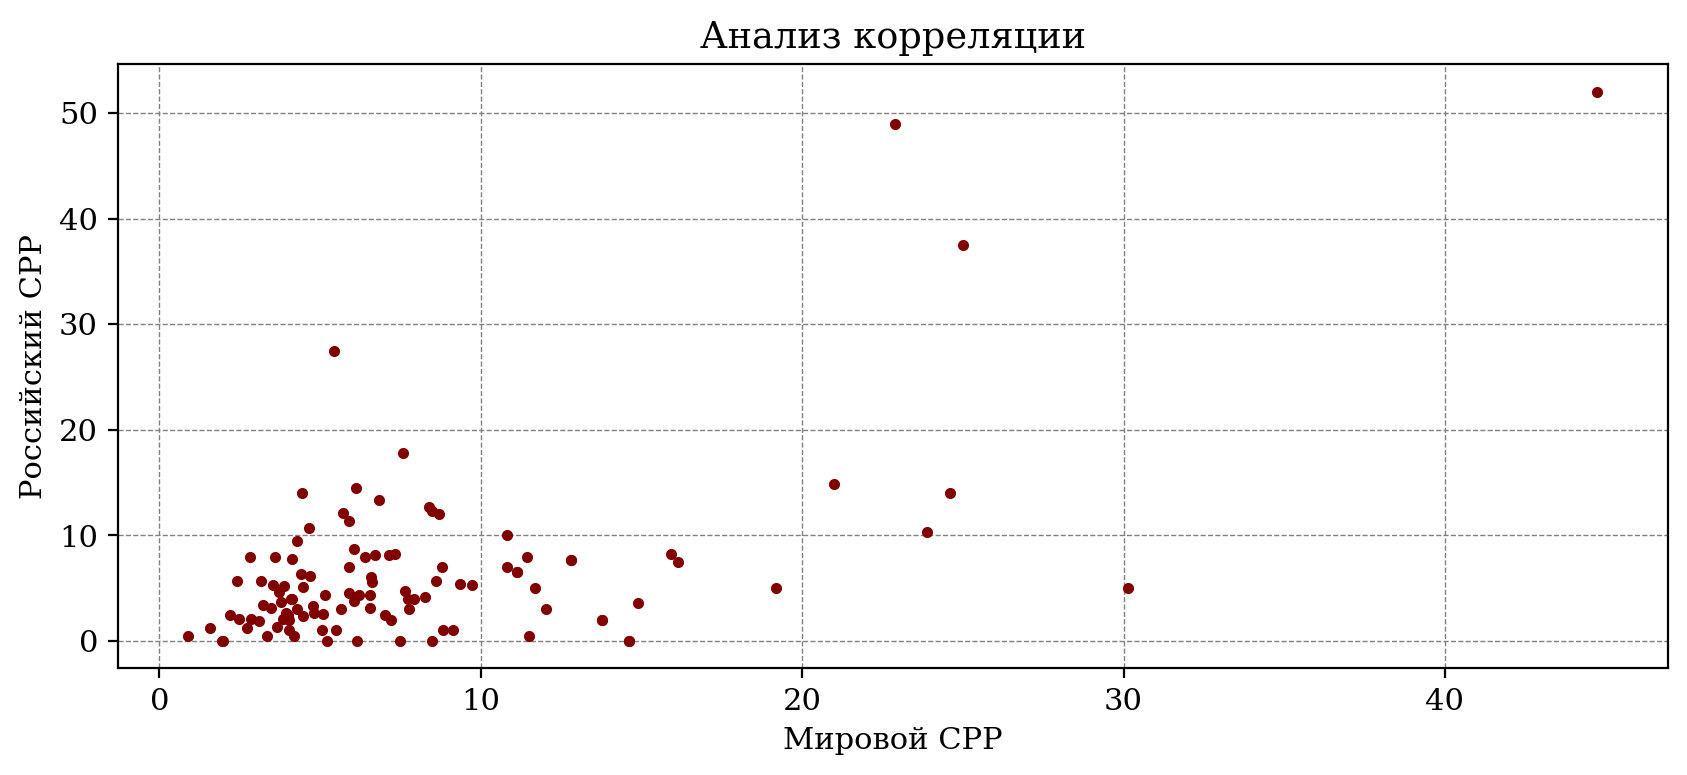

In [26]:
# Корреляция CPP мира к России

fig01 = plt.figure(num = 0)

ax01 = fig01.add_subplot()

ax01.set_title('Анализ корреляции')
ax01.set_xlabel(r'Мировой CPP')
ax01.set_ylabel(r'Российский CPP')

ax01.plot(Result['CPP'], Result['CPP (Russia)'], 'o', color='maroon')

(array([34., 28., 20., 12.,  6.,  5.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ,
        28.6, 31.2, 33.8, 36.4, 39. , 41.6, 44.2, 46.8, 49.4, 52. ]),
 <BarContainer object of 20 artists>)

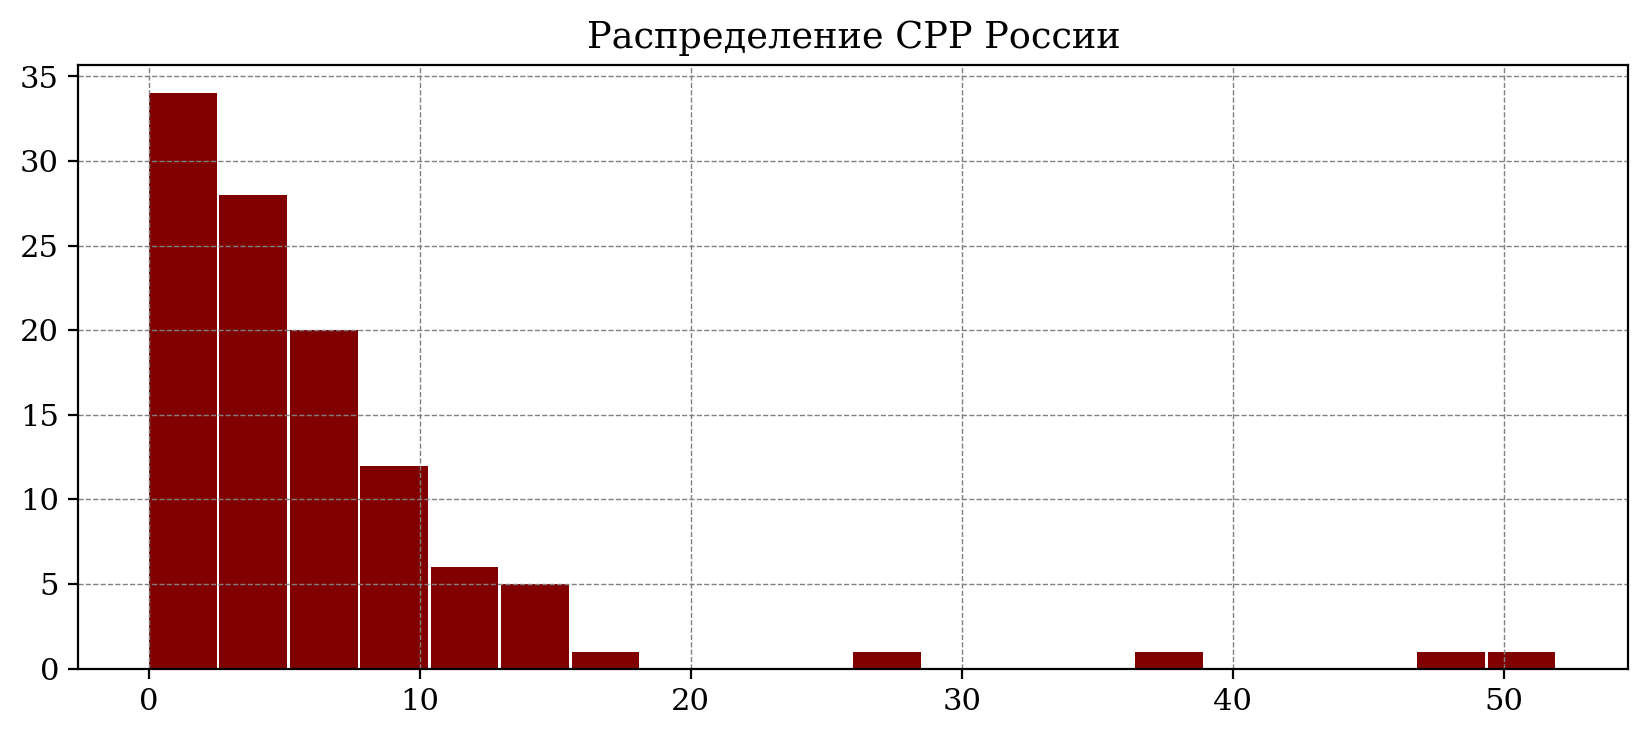

In [27]:
fig02 = plt.figure(num = 0)

ax02 = fig02.add_subplot()

ax02.set_title('Распределение CPP России')

ax02.hist(Result['CPP (Russia)'],bins=20, width = 2.5, color='maroon')

(array([10., 35., 23., 16.,  8.,  5.,  5.,  0.,  1.,  1.,  3.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.89189189,  3.08403887,  5.27618585,  7.46833283,  9.66047981,
        11.85262678, 14.04477376, 16.23692074, 18.42906772, 20.6212147 ,
        22.81336168, 25.00550865, 27.19765563, 29.38980261, 31.58194959,
        33.77409657, 35.96624355, 38.15839053, 40.3505375 , 42.54268448,
        44.73483146]),
 <BarContainer object of 20 artists>)

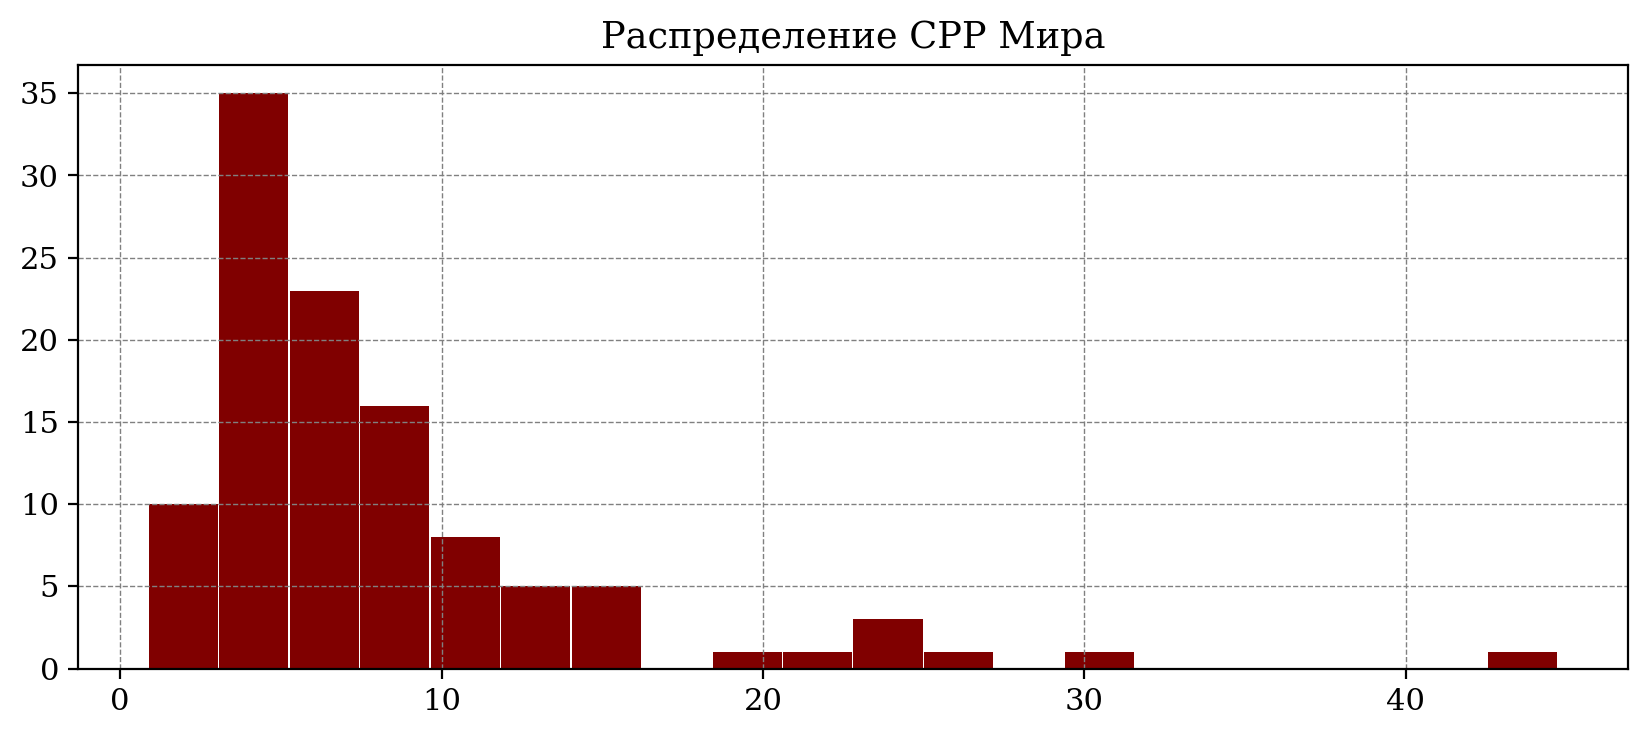

In [28]:
fig03 = plt.figure(num = 0)

ax03 = fig03.add_subplot()

ax03.set_title('Распределение CPP Мира')

ax03.hist(Result['CPP'],bins=20, width=2.15, color='maroon')